# Fig2 fitness prediction on Kemble data :
Ref: K EMBLE , H., E ISENHAUER , C., C OUCE , A., C HAPRON , A., M AGNAN , M., G AUTIER , G., L E N AGARD ,H., N GHE , P., AND T ENAILLON , O. Flux, toxicity, and expression costs generate complex genetic interactions in a metabolic pathway. Science Advances 6, 23 (2020), eabb2236.

In [2]:
import os 
if not os.path.isdir('img/'):
    os.mkdir('img/')

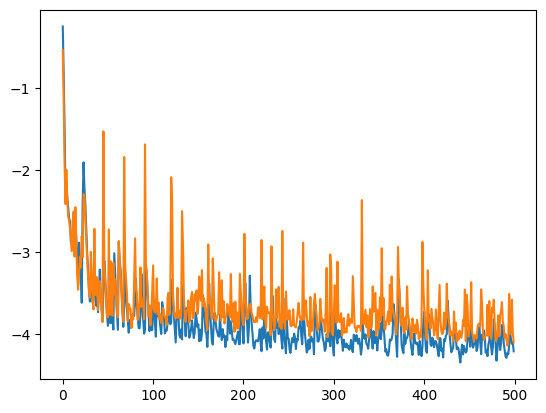

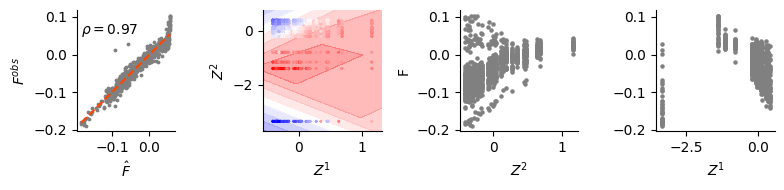

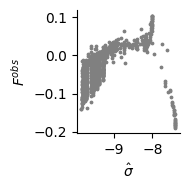

In [5]:
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace
from numpy.random import choice
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Here you can change the path into your file's path 
file_name = "data/data_epis_1.csv"
# file_name = "./data/data_env_2.csv" 
nb_gene = 2 
data = Data_model(file_name, nb_gene)
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.2))
model = DLIM(nb_gene, nb_state=37, hid=16, nb_layer=0)

train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_data], :]

losses = train(model, train_data, lr=1e-2, nb_epoch=500, bsize=16, val_data=val_data, wei_dec=1e-2)
train_l, val_l = zip(*losses)
# plot the training and validation curve 
plt.plot(train_l)
plt.plot(val_l)
plt.show()

fit, var, _ = model(val_data[:, :-1].long(), detach=True)

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
ax.scatter(fit, val_data[:, [-1]].detach(), s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = pearsonr(fit.flatten(), val_data[:, [-1]].flatten())[0]
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")

model.plot(bx, data)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)
ax.set_aspect(1)

fit_a, var_a, lat_a = model(data[:, :-1].long(), detach=True)
cx.scatter(lat_a[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat_a[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
dx.set_xlabel("$Z^1$")
cx.set_xlabel("$Z^2$")
plt.tight_layout()
# plt.savefig("./img/fit_e2.png", dpi=300, transparent=True)
plt.show()

fig, ax = plt.subplots(1, figsize=(2, 2), sharey=True)
ax.scatter(var_a.log(), data[:, [-1]], s=3, c="grey")
ax.set_xlabel("$\\hat{\\sigma}$")
ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig("./img/fit_var_e2.png", dpi=300, transparent=True)
plt.show()

# Fig 3 simulated data 

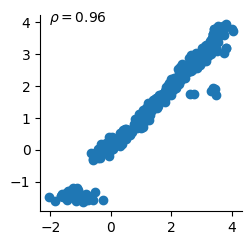

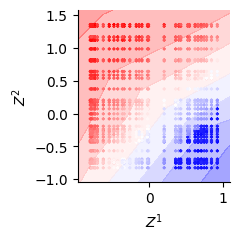

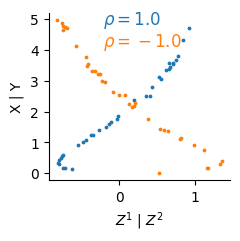

In [6]:
from src.model import DLIM
from src.utils import Data_model, train
from src.sim_data import Simulated
from numpy import mean
from numpy.random import choice, shuffle
import matplotlib.pyplot as plt
from numpy import linspace, meshgrid
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

# there are: bio, add, quad, saddle, hat, exp 
type_f = "bio"
nb_var = 36
data = Simulated(nb_var, type_f, comp=False)

train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7))
model = DLIM(2, nb_state=nb_var, hid=16, nb_layer=0)

train_data = data[train_id, :]
val_id = [i for i in range(data.data.shape[0]) if i not in train_id]
shuffle(val_id)
val_data = data[val_id[:int(data.data.shape[0]*0.3)], :]

losses = train(model, train_data, lr=1e-2, nb_epoch=300, bsize=64, wei_dec=1e-3, val_data=val_data)
train_l, val_l = zip(*losses)

fit, var, lat = model(val_data[:, :-1].long(), detach=True)

fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
ax.scatter(fit, val_data[:, [-1]])
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
score = r2_score(fit.flatten(), val_data[:, [-1]].flatten())
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")
# plt.savefig(f"./img/{type_f}_val_synth.png", dpi=300, transparent=True)
plt.show()

fig, bx = plt.subplots(1, figsize=(2.5, 2.5))
model.plot(bx)
bx.scatter(model.genes[0][data.data[:, 0].long()].detach(),
           model.genes[1][data.data[:, 1].long()].detach(),
           c=data.data[:, -1], s=2, cmap="bwr", marker="x")
for el in ["top", "right"]:
    bx.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig(f"./img/{type_f}_land_synth.png", dpi=300, transparent=True)
plt.show()


fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
score_A = spearmanr(model.genes[0].detach(), data.A)[0]
score_B = spearmanr(model.genes[1].detach(), data.B)[0]
ax.scatter(model.genes[0].detach(), data.A, c="C0", s=3)
ax.scatter(model.genes[1].detach(), data.B, c="C1", s=3)
ax.set_xlabel("$Z^1$ | $Z^2$")
ax.set_ylabel("X | Y")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.annotate(f"$\\rho={score_A:.1f}$", xy=(0.3, 0.93), xycoords="axes fraction", fontsize=12, c="C0")
ax.annotate(f"$\\rho={score_B:.1f}$", xy=(0.3, 0.8), xycoords="axes fraction", fontsize=12, c="C1")
plt.tight_layout()
plt.savefig(f"./img/{type_f}_corz_synth.svg", dpi=300, transparent=True)
plt.show()

# Fig 4: extrapolation based on latent space 

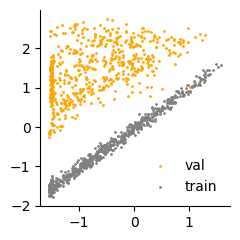

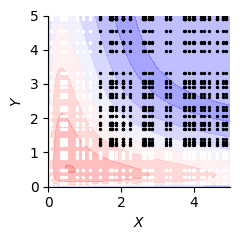

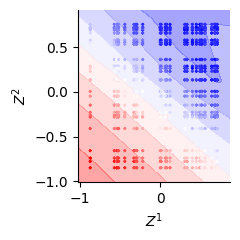

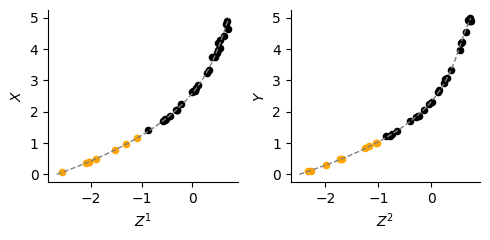

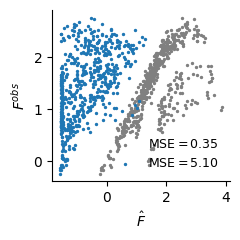

In [9]:
from torch import tensor, cat
from src.model import DLIM
from src.utils import Data_model, train
from src.sim_data import Simulated
from numpy import mean
from numpy.random import choice, shuffle, sample
import matplotlib.pyplot as plt
from numpy import linspace, meshgrid
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import matplotlib.patches as mpatches

# choose the landscape: bio, add, quad, saddle, hat, exp 
type_f = "bio"
nb_state = 36
data = Simulated(nb_state, type_f)

model = DLIM(2, nb_state=nb_state, hid=32, nb_layer=1)

thres = 1.2
# choose the data for training 
A_id = [i for i, el  in enumerate(data.A) if el >= 1.2]
B_id = [i for i, el  in enumerate(data.B) if el >= 1.2]
nA_id = [i for i, el  in enumerate(data.A) if i not in A_id]
nB_id = [i for i, el  in enumerate(data.B) if i not in B_id]
train_id = [i for i, el  in enumerate(data.data) if el[0] in A_id and el[1] in B_id]
len(train_id)
train_data = data[train_id, :]
val_id = [i for i in range(data.data.shape[0]) if i not in train_id]
val_data = data[val_id, :]

losses = train(model, train_data, lr=1e-2, nb_epoch=300, bsize=64, wei_dec=1e-3, val_data=val_data)
train_l, val_l = zip(*losses)


fit_v, vari_v, lat_v = model(val_data[:, :-1].long(), detach=True)
fit_t, var_t, lat_t = model(train_data[:, :-1].long(), detach=True)

fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
ax.scatter(fit_v, val_data[:, [-1]], s=1, label="val", c="orange")
ax.scatter(fit_t, train_data[:, [-1]], s=1, label="train", c="grey")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"./img/{type_f}_fit_quality.png", dpi=300, transparent=True)
plt.show()

fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
data.plot(ax)
ax.scatter(data.A[data.data[train_id, 0].long()], data.B[data.data[train_id, 1].long()], s=2, marker="o", c="black")
ax.scatter(data.A[data.data[val_id, 0].long()], data.B[data.data[val_id, 1].long()], s=2, marker="o", c="white")

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig(f"./img/{type_f}_land_data.png", dpi=300, transparent=True)
plt.show()

fig, bx = plt.subplots(1, figsize=(2.5, 2.5))
model.plot(bx)
bx.scatter(model.genes[0][data.data[train_id, 0].long()].detach(),
           model.genes[1][data.data[train_id, 1].long()].detach(),
           c=data.data[train_id, -1], s=2, cmap="bwr", marker="x")
for el in ["top", "right"]:
    bx.spines[el].set_visible(False)
# bx.set_aspect(1)
plt.tight_layout()
plt.savefig(f"./img/{type_f}_land_pred.png", dpi=300, transparent=True)
plt.show()

model.train_convert(A_id, data.A[A_id], 0)
model.train_convert(B_id, data.B[B_id], 1)
model.update_emb(nA_id, data.A[nA_id], 0)
model.update_emb(nB_id, data.B[nB_id], 1)

fig, (ax, bx) = plt.subplots(1, 2, figsize=(5, 2.5))
ax.scatter(model.genes[0][A_id].detach(), data.A[A_id], c="black", s=20)
ax.scatter(model.genes[0][nA_id].detach(), data.A[nA_id], c="orange", s=20)
ax.plot(np.polyval(model.conversion[0], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
bx.scatter(model.genes[1][B_id].detach(), data.B[B_id], c="black", s=20)
bx.scatter(model.genes[1][nB_id].detach(), data.B[nB_id], c="orange", s=20)
bx.plot(np.polyval(model.conversion[1], np.linspace(0, 5, 100)), np.linspace(0, 5, 100), linewidth=1, linestyle="--", c="grey")
ax.set_ylabel("$X$")
ax.set_xlabel("$Z^1$")
bx.set_ylabel("$Y$")
bx.set_xlabel("$Z^2$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
plt.tight_layout()
plt.savefig(f"./img/{type_f}_cor_bio.png", dpi=300, transparent=True)
plt.show()

fit_n, var_n, lat_n = model(val_data[:, :-1].long(), detach=True)
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
score = ((fit_n.flatten() - val_data[:, [-1]].flatten())**2).mean()
score_v = ((fit_v.flatten() - val_data[:, [-1]].flatten())**2).mean()

ax.scatter(fit_n, val_data[:, [-1]], s=2, c="grey", label=f"MSE$={score:.2f}$")
ax.scatter(fit_v, val_data[:, [-1]], s=2, c="C0", label=f"MSE$={score_v:.2f}$")

ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.legend(frameon=False, ncol=1, fontsize=9)
plt.tight_layout()
plt.savefig(f"./img/{type_f}new_fit.svg", dpi=300, transparent=True)
plt.show()

# Fig5. Landscape complexity

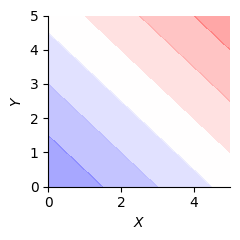

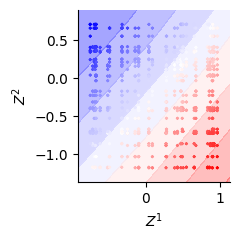

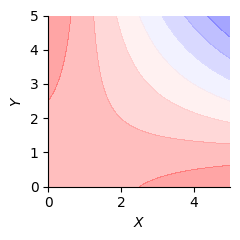

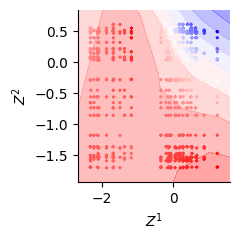

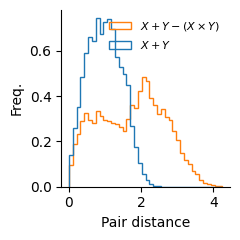

In [17]:
from src.model import DLIM
from src.utils import Data_model, train
from src.sim_data import Simulated
from numpy import mean, var
from numpy.random import choice
import matplotlib.pyplot as plt
from numpy import linspace, meshgrid
import numpy as np



# choose different landscape and compare with additive model
type_f = 'comp'
tmp = []
for cor in ["add", type_f]:
    model = DLIM(2, nb_state=36, hid=16, nb_layer=0)
    data = Simulated(36, cor)
    train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7))

    train_data = data[train_id, :]
    val_data = data[[i for i in range(data.data.shape[0]) if i not in train_data], :]

    losses = train(model, train_data, lr=1e-2, nb_epoch=400, bsize=64, wei_dec=1e-3)
    fit, var, lat = model(data[:, :-1].long(), detach=True)
    differences = lat[:, np.newaxis, :] - lat[np.newaxis, :, :]
    distances = np.linalg.norm(differences, axis=2)
    tmp += [distances.flatten()]
    if type_f == 'comp':
        lab = "$X+Y - (X \\times Y)$"
    elif type_f == 'quad':
        lab = "$X \\times Y$"
    elif type_f == 'hat':
        lab = "$sin(X^2 + Y^2)$"
    elif type_f == 'saddle':
        lab = "$X^2 - Y^2$"
    elif type_f == 'exp':
        lab = "$ 10 \\times (e^{-(2-X)^2 - (2-Y)^2})$"
        
    fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
    data.plot(ax)

    for el in ["top", "right"]:
        ax.spines[el].set_visible(False)
    plt.tight_layout()
    plt.show()

    fig, bx = plt.subplots(1, figsize=(2.5, 2.5))
    model.plot(bx)
    bx.scatter(model.genes[0][data.data[train_id, 0].long()].detach(),
            model.genes[1][data.data[train_id, 1].long()].detach(),
            c=data.data[train_id, -1], s=2, cmap="bwr", marker="x")
    for el in ["top", "right"]:
        bx.spines[el].set_visible(False)
    plt.tight_layout()
    plt.show()

fig, cx = plt.subplots(1, 1, figsize=(2.5, 2.5))
for el in ["top", "right"]:
    cx.spines[el].set_visible(False)
cx.hist(tmp, density=True, histtype="step", label=["$X+Y$", lab], bins=40)

cx.legend(frameon=False, fontsize=8)
cx.set_xlabel("Pair distance", fontsize=10)
cx.set_ylabel("Freq.", fontsize=10)
plt.tight_layout()
plt.savefig("./img/fig_5_c.png", dpi=300, transparent=True)
plt.show()


# Fig 6: application in RNA contact prediction 

## Generate RNA  data 

In [ ]:
from random import choice
from RNA import fold_compound
NUC = ["A", "C", "G", "U"]
seq =    "AAAAAAAAAAAAAA"
struct = "..((((....))))"

len_seq = len(seq)
nb_seq = 100000
seen = set()
paired_position = True
paired_pos = [(i, j) for i in range(len_seq) for j in range(len_seq) if i>j]
print(len(paired_pos))
with open("data/rand_seq_paired.dat", "w") as out:
    for si in range(nb_seq):
        rand_seq = "".join([choice(NUC) for _ in range(len_seq)])
        if rand_seq not in seen:
            nrj = fold_compound(rand_seq).eval_structure(struct)
            if nrj < 0:
                if not paired_position:
                    seq= ",".join([n for n in rand_seq])
                else:
                    seq= ",".join([rand_seq[i]+"+"+rand_seq[j] for i, j in paired_pos])
                out.write(f"{seq},{nrj}\n")
                seen.add(rand_seq)

## train model on RNA data 

/tmp/ipykernel_1843275/2957659807.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bx.set_xticklabels([1, 5, 10, 14])


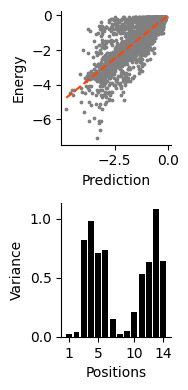

In [18]:
from src.model import DLIM
from src.utils import Data_model, train
from numpy import mean, linspace, array, meshgrid
from numpy.random import choice
import numpy as np
from torch import tensor, float32 as tfloat, cat as tcat
import matplotlib.pyplot as plt

data = Data_model("./data/rand_seq.dat", 14)
model = DLIM(14, nb_state=4, hid=16, nb_layer=3)

train_data = data

losses = train(model, train_data, lr=1e-2, nb_epoch=2000, bsize=128)

fit, var, _ = model(data[:, :-1].long())
fit, var = fit.detach(), var.detach()

fig, (ax, bx) = plt.subplots(2, figsize=(2, 4))
ax.scatter(fit, data[:, [-1]], s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("Prediction")
ax.set_ylabel("Energy")
lat_space = model.genes

cov_l = np.zeros(14)
for i in range(14):
    distances = abs(lat_space[i][:, np.newaxis] - lat_space[i][np.newaxis, :])
    cov_l[i] = distances.var()

bx.bar(range(14), height=cov_l, color="black")

bx.set_xlabel("Positions")
bx.set_ylabel("Variance")
bx.set_xticklabels([1, 5, 10, 14])
bx.set_xticks([0, 4, 9, 13])
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
plt.tight_layout()
# plt.savefig("img/rna_res.png", dpi=300, transparent=True)
plt.show()

# Fig.7: regularisation based on knowledge graph 

## step1: get knowledge graph information 

In [ ]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

file_data = "./data/data_env_1.csv"
fit_dic = {("WT", "WT"): 0}
all_mut_1 = set()
all_mut_2 = set()
for l in open(file_data):
    mut_1, mut_2, fit = l.strip().split(",")
    if fit == "":
        fit = 0
    fit_dic[(mut_1, mut_2)] = float(fit)

    all_mut_1.add(mut_1)
    all_mut_2.add(mut_2)

all_mut_1 = list(all_mut_1)
all_mut_2 = list(all_mut_2)
cov_mat_1 = np.zeros((len(all_mut_1), len(all_mut_1)))
cov_mat_2 = np.zeros((len(all_mut_2), len(all_mut_2)))

fit_m1 = {mut_1: [fit_dic[(mut_1, mut_2)] for mut_2 in all_mut_2] for mut_1 in all_mut_1}
for i, mi1 in enumerate(all_mut_1):
    for j, mj1 in enumerate(all_mut_1[i+1:], start=i+1):
        cov_mat_1[i, j] = pearsonr(fit_m1[mi1], fit_m1[mj1])[0]

fit_m2 = {mut_2: [fit_dic[(mut_1, mut_2)] for mut_1 in all_mut_1] for mut_2 in all_mut_2}
for i, mi2 in enumerate(all_mut_2):
    for j, mj2 in enumerate(all_mut_2[i+1:], start=i+1):
        cov_mat_2[i, j] = pearsonr(fit_m2[mi2], fit_m2[mj2])[0]

thres_1 = np.percentile(cov_mat_1.flatten(), 90)
thres_2 = np.percentile(cov_mat_2.flatten(), 90)


with open("./data/data_const.dat", "w") as out:
    for i, mi1 in enumerate(all_mut_1):
        for j, mj1 in enumerate(all_mut_1[i+1:], start=i+1):
            if cov_mat_1[i, j] > thres_1:
                out.write(f"0,{mi1},{mj1}\n")

    for i, mi2 in enumerate(all_mut_2):
        for j, mj2 in enumerate(all_mut_2[i+1:], start=i+1):
            if cov_mat_2[i, j] > thres_2:
                out.write(f"1,{mi2},{mj2}\n")

### step2: run the code in .py file 

In [ ]:
# this file get to know how the regulization on latent space will change 
import sys 
sys.path.append('../')
from src.model import DLIM
from src.utils import Data_model, train
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from numpy import mean, logspace, std
from numpy.random import choice, seed
import matplotlib.pyplot as plt
from multiprocessing import Pool
import joblib 

data = Data_model("./data/data_env_1.csv", 2, const_file="./data/data_const.dat")
data_no = Data_model("./data/data_env_1.csv", 2)
val_frac = logspace(-2, 0.1, num=7)
val_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.3))
train_full_id = [i for i in range(data.data.shape[0]) if i not in val_id]
train_full_data = data[train_full_id, :]
val_data = data[val_id, :]

def run_one(args):
    i, frac, wei_const = args
    seed(42 + i)
    train_id = choice(range(train_full_data.shape[0]), int(train_full_data.shape[0]*frac))
    model = DLIM(2, nb_state=37, hid=32, nb_layer=1)
    model_no = DLIM(2, nb_state=37, hid=32, nb_layer=1)

    train_data = train_full_data[train_id, :]

    _ = train(model, train_data, const=data.const, lr=1e-2, wei_const=wei_const, wei_dec=1e-3, nb_epoch=300, bsize=64)
    _ = train(model_no, train_data, lr=1e-2, wei_dec=1e-3, nb_epoch=300, bsize=64)

    fit = model(val_data[:, :-1].long())[0].detach().squeeze(-1)
    fit_no = model_no(val_data[:, :-1].long())[0].detach().squeeze(-1)
    cor_w = pearsonr(fit, val_data[:, -1])[0]
    cor_n = pearsonr(fit_no, val_data[:, -1])[0]
    return cor_w, cor_n

result = {}
res_w, res_n = [], []
pool = Pool(20)
weight = 10

for frac in val_frac:
    res = pool.map(run_one, [(i, frac, weight) for i in range(10)])
    tmp_w, tmp_n = zip(*res)
    res_w += [tmp_w]
    res_n += [tmp_n]
result = {
    'reg': res_w,
    'no': res_n
}
joblib.dump(result, 'results/regularization_evol_nb_data.joblib')



### step3: plot the results

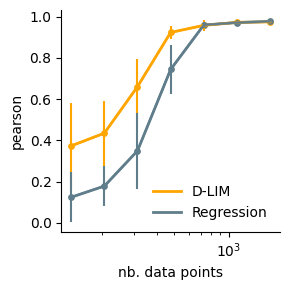

In [29]:
import matplotlib.pyplot as plt
import joblib 
from numpy import mean, logspace, std
from src.utils import Data_model 
data = Data_model("./data/data_env_1.csv", 2)
val_frac = logspace(-1, 0.1, num=7)
result = joblib.load('results/regularization_evol_nb_data.joblib')
res_w = result['reg']
res_c = result['no']
fig, ax = plt.subplots(figsize=(3, 3))
color1 = '#ffa500'  # modern orange
color2 = '#607d8b'  # light gray-blue
ax.plot(val_frac* data.data.shape[0], [mean(el) for el in res_w], c=color1, lw=2, label="D-LIM")
ax.scatter(val_frac* data.data.shape[0], [mean(el) for el in res_w], c=color1, s=15)
ax.errorbar(val_frac* data.data.shape[0], [mean(el) for el in res_w], yerr=[std(el) for el in res_w], c=color1)

ax.plot(val_frac* data.data.shape[0], [mean(el) for el in res_c], c=color2, lw=2, label="Regression")
ax.scatter(val_frac* data.data.shape[0], [mean(el) for el in res_c], c=color2, s=15)
ax.errorbar(val_frac* data.data.shape[0], [mean(el) for el in res_c], yerr=[std(el) for el in res_c], c=color2)

ax.set_xscale("log")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.set_ylabel("pearson")
ax.set_xlabel("nb. data points")
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig("./img/reg_dlim_comp.png", dpi=300, transparent=True)
plt.show()